In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Optional: move to the desired location:
%cd drive/My Drive/Colab/Shaki_Vai

Mounted at /content/drive
/content/drive/My Drive/Colab/Shaki_Vai


In [ ]:
!pip install HydroErr
!pip install SeqMetrics

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import HydroErr as he
from SeqMetrics import RegressionMetrics
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.models import load_model

  Preparing metadata (setup.py) ... done
  Created wheel for HydroErr: filename=HydroErr-1.24-py3-none-any.whl size=20184 sha256=d3b694c190af30d349510b413c0300056e3651da9c9311879ba092dd7ae4eeea
  Stored in directory: /root/.cache/pip/wheels/8d/e9/18/d0b606eee232002e55f79178ae1077fb4bb082600f70cfe383
Successfully built HydroErr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
def evaluate_model_without_predictions(best_model, X_test, y_test, history):
    # Evaluate the model on the test data
    loss, mae, rmse = best_model.evaluate(X_test, y_test)
    training_time = history.history.get('time')
    print("Training time:", training_time, "seconds")
    print("Train Loss:", loss)
    print("Train MAE:", mae)
    print("Train RMSE:", rmse)

    # # Plot training history
    # plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    # plt.title('Model Loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Validation'], loc='upper right')
    # plt.show()


def evaluate_predictions(test_results):
    # Calculate additional metrics
    y_true = test_results['Actuals']
    y_pred = test_results['Test Predictions']
    # mse = mean_squared_error(y_true, y_pred)
    # mae = mean_absolute_error(y_true, y_pred)
    # rmse = np.sqrt(mse)
    rmse = he.rmse(y_pred, y_true)
    NSE1 = he.nse(y_pred, y_true)
    r2 = he.r_squared(y_pred, y_true)
    mse = he.mse(y_pred, y_true)
    mae = he.mae(y_pred, y_true)
    KGE_09 = he.kge_2009(y_pred, y_true)
    KGE_12 = he.kge_2012(y_pred, y_true)

    er = RegressionMetrics(y_true, y_pred)
    rsr = er.rsr()

    # Print metrics
    print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
    print("NSE Score: {:.2f}".format(NSE1))
    print("R-squared (R2) Score: {:.2f}".format(r2))
    print("Mean Squared Error (MSE): {:.2f}".format(mse))
    print("Mean Absolute Error (MAE): {:.2f}".format(mae))
    print("RSR (RSR): {:.2f}".format(rsr))
    print("KGE_09 Score: {:.2f}".format(KGE_09))
    print("KGE_12 Score: {:.2f}".format(KGE_12))

    # Visualize results
    plt.plot(y_pred, label='Predictions')
    plt.plot(y_true, label='Actual')
    plt.title('Observed Results vs Simulated Results')
    plt.legend()
    plt.show()

In [ ]:
df1=pd.read_csv('Data/SS.01 from 1981-2017.csv')
df2=pd.read_csv('Data/SS.02 from 1981-2017.csv')
df7=pd.read_csv('Data/SS.07 from 1981-2017.csv')
df9=pd.read_csv('Data/SS.09 from 1981-2017.csv')
df10=pd.read_csv('Data/SS.10 from 1981-2017.csv')
df101=pd.read_csv('Data/SS.101 from 1981-2017.csv')
df108=pd.read_csv('Data/SS.108 from 1981-2017.csv')
df001=pd.read_csv('Data/SS.001 from 1981-2017.csv')

# Parameters
# file_path = 'Data/SS.01 from 1981-2017.csv'
saved_model_path = 'NewSavedModels/avg_3_month.keras'
adapted_model_path = "NewSavedModels/adapted_SS001_3_month.keras"
save_csv_path = 'ModelOutputs/adapted_model_test_results_S001_3_month.csv'
top_x = 13
window_size = 1
step = 2

# Read File
# df=pd.read_csv(file_path)
df = df001

# Dataset preprocess
df['Date Time'] = pd.to_datetime(df['Date'], dayfirst=False)
df['Day'] = df['Date Time'].dt.day
df['Month'] = df['Date Time'].dt.month
df['Year'] = df['Date Time'].dt.year
df.set_index('Date Time', inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.drop(['Day'], axis=1, inplace=True)
df.head()

,yt,yt-1,yt-2,yt-3,yt-4,yt-5,yt-6,yt-7,yt-8,yt-9,...,CR-5,CR-6,CR-7,CR-8,CR-9,CR-10,CR-11,CR-12,Month,Year
Date Time,,,,,,,,,,,,,,,,,,,,,
1981-01-01,9.28,9.44,9.37,8.84,8.34,7.90,7.88,7.86,7.96,8.01,...,1033.0,1773.0,2033.5,2326.0,2444.0,2626.5,2654.5,2763.0,1,1981
1981-02-01,8.94,9.28,9.44,9.37,8.84,8.34,7.90,7.88,7.86,7.96,...,494.0,1063.0,1803.0,2063.5,2356.0,2474.0,2656.5,2684.5,2,1981
1981-03-01,8.77,8.94,9.28,9.44,9.37,8.84,8.34,7.90,7.88,7.86,...,326.5,575.5,1144.5,1884.5,2145.0,2437.5,2555.5,2738.0,3,1981
1981-04-01,8.61,8.77,8.94,9.28,9.44,9.37,8.84,8.34,7.90,7.88,...,290.5,456.5,705.5,1274.5,2014.5,2275.0,2567.5,2685.5,4,1981
1981-05-01,8.47,8.61,8.77,8.94,9.28,9.44,9.37,8.84,8.34,7.90,...,414.0,426.5,592.5,841.5,1410.5,2150.5,2411.0,2703.5,5,1981


In [ ]:
# # Mutual Information
# X = df  # Features (including luding the target)
# y = df['yt']  # Target variable
# # Compute mutual information
# mutual_info = mutual_info_regression(X, y)
# # Create a DataFrame to display the mutual information scores for each feature
# mi_scores_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Mutual Information Score'])
# # Sort the DataFrame by mutual information score in descending order
# mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)

# print(mi_scores_df.head(20))
# # Get the top 20 features
# top_features = mi_scores_df.head(20)

# # Plot the horizontal bar plot
# plt.figure(figsize=(10, 8))
# plt.barh(top_features.index, top_features['Mutual Information Score'], color='skyblue')
# plt.xlabel('Mutual Information Score')
# plt.ylabel('Features')
# plt.title('Top 20 Features by Mutual Information Score')
# plt.gca().invert_yaxis()  # Invert y-axis to display the highest score at the top
# plt.show()

In [ ]:
# Select dataset with top  Mutual Information Scores
# dataset_top_x = df.loc[:, mi_scores_df.index[:top_x]]
dataset_top_x = df[['yt', 'yt-1', 'yt-2', 'CR-9', 'CR-8', 'CR-10', 'CR-11', 'TmeanLag11', 'yt-3', 'Month', 'TmeanLag10', 'TmeanLag4', 'yt-12']]

# Print the shapes of the datasets
print(f"Dataset_top_{top_x}:", dataset_top_x.shape)

Dataset_top_13: (444, 13)


In [ ]:
# Define window size (number of time steps)
def generate_time_series_data(df, window_size, step):

    # Define lists to store features and target
    X_features = []
    y_target = []

    # Iterate over each row in the DataFrame
    for i in range(df.shape[0] - window_size-step):
        # Extract the features for the current window
        window_features = []
        for j in range(window_size):
            window_features.append(df.iloc[i + j, :].values)
        X_features.append(window_features)

        # Append the target value (12 time steps ahead) to the target list
        y_target.append(df.iloc[i + window_size + step, 0])  # Assuming the target is in the first column

    # Convert lists to numpy arrays
    X = np.array(X_features)
    y_target = np.array(y_target)
    y=np.reshape(y_target, (len(y_target),1))
    # Print the shapes of X and y
    return X, y


def scale_data(features, target):
    # Reshape the features data to 2D (samples * time steps, features) for scaling
    features_2d = features.reshape(-1, features.shape[-1])
    # Apply MinMaxScaler to features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features_2d)
    # Apply MinMaxScaler to target
    scaled_target = scaler.fit_transform(target)
    # Reshape the scaled features data back to 3D (samples, time steps, features)
    scaled_features = scaled_features.reshape(features.shape)
    return scaled_features, scaled_target, scaler

In [ ]:
data_x, target_x = generate_time_series_data(dataset_top_x, window_size, step)
dataset_1, target_1, scaler = scale_data(data_x, target_x)
X_train, X_test = dataset_1[:-65], dataset_1[-65:]
y_train, y_test = target_1[:-65], target_1[-65:]
n_features = X_train.shape[2]
n_features

13

In [ ]:
## 1 Month
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data_x.reshape(-1, data_x.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target_x)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data_x.shape)
# dataset_1, target_1, scaler = scale_data(data_x, target_x)

# ## 2 Month
# # Reshape the features data to 2D (samples * time steps, features) for scaling
# features_2d = data_x.reshape(-1, data_x.shape[-1])
# # Apply MinMaxScaler to features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features_2d)
# # Apply MinMaxScaler to target
# target_1 = scaler.fit_transform(target_x)
# # Reshape the scaled features data back to 3D (samples, time steps, features)
# dataset_1 = scaled_features.reshape(data_x.shape)


#dataset_1, target_1 = scale_data(data_6, target_6)
# X_train, X_test = dataset_1[:-65], dataset_1[-65:]
# y_train, y_test = target_1[:-65], target_1[-65:]
# n_features= X_train.shape[2]
# n_features

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)]

def create_model(batch_size=16, optimizer='SGD', activation='leaky_relu', dropout_rate=0.2, lstm_units=128, dense_units=64, seed_value=42, model_path=saved_model_path):
    np.random.seed(seed_value)  # Set seed for NumPy
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window_size, n_features)))

    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.5))
    else:
        model.add(Activation(activation))

    model.add(LSTM(lstm_units, return_sequences=True))

    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation(activation))

    model.add(Dropout(dropout_rate))
    model.add(LSTM(int(lstm_units/2), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.add(Dense(1))

    if optimizer == 'SGD':
        optimizer = SGD()
    elif optimizer == 'RMSprop':
        optimizer = RMSprop()
    elif optimizer == 'Adam':
        optimizer = Adam()

    # Load the weights
    model.load_weights(model_path)
    # # Freeze all layers
    # for layer in model.layers:
    #     layer.trainable = False
    for layer in model.layers[:-4]:
        layer.trainable = False

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', rmse])

    return model

3/3 [==============================] - 1s 5ms/step
Before Adaptation:
Root Mean Squared Error (RMSE): 0.14
NSE Score: 0.76
R-squared (R2) Score: 0.81
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.10
RSR (RSR): 0.49
KGE_09 Score: 0.71
KGE_12 Score: 0.71


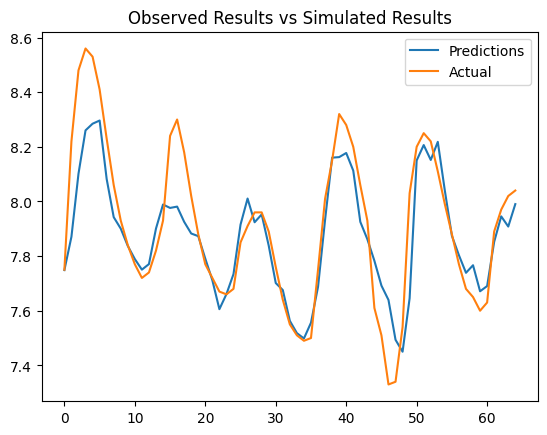

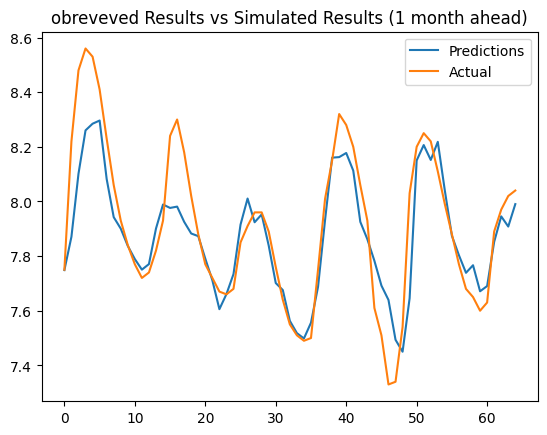

In [ ]:
import time
# Create the model using the best parameters
best_model = create_model(batch_size=8, lstm_units=128, dropout_rate=0.15, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.25), model_path=saved_model_path)
# Start the timer
# start_time = time.time()
# # Train the model with the entire training data
# history = best_model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=callbacks)
# # End the timer
# end_time = time.time()
# # Calculate the elapsed time
# training_time = end_time - start_time
# # Evaluate the model on the test data
# loss, mae, rmse = best_model.evaluate(X_test, y_test)
# print("Training time:", training_time, "seconds")
# print("Train Loss:", loss)
# print("Train MAE:", mae)
# print("Train RMSE:", rmse)

predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions':predictions_1d, 'Actuals':y_test_1d})
# test_results

y_true = test_results['Actuals']
y_pred = test_results['Test Predictions']
# # Calculate metrics
# mse = mean_squared_error(y_true, y_pred)
# mae = mean_absolute_error(y_true, y_pred)
# rmse = np.sqrt(mse)
# r2 = he.r_squared(y_pred, y_true)
# NSE1=he.nse(y_pred, y_true)
# KGE_12= he.kge_2012(y_pred, y_true)
# print("Mean Squared Error (MSE): {:.2f}".format(mse))
# print("Mean Absolute Error (MAE): {:.2f}".format(mae))
# print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
# print("NSE Score: {:.2f}".format(NSE1))
# print("R-squared (R2) Score: {:.2f}".format(r2))
# print("KGE_12 Score: {:.2f}".format(KGE_12))
print("Before Adaptation:")
evaluate_predictions(test_results)

# Visualize results
import matplotlib.pyplot as plt
plt.plot(y_pred, label='Predictions')
plt.plot(y_true, label='Actual')
plt.title('obreveved Results vs Simulated Results (1 month ahead)')
plt.legend()
plt.show()

Beginning Adaptation
Epoch 1/200
40/40 [==============================] - 8s 40ms/step - loss: 0.0053 - mae: 0.0533 - rmse: 0.0690 - val_loss: 0.0030 - val_mae: 0.0402 - val_rmse: 0.0457
Epoch 2/200
40/40 [==============================] - 0s 10ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0651 - val_loss: 0.0039 - val_mae: 0.0503 - val_rmse: 0.0560
Epoch 3/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0047 - mae: 0.0502 - rmse: 0.0639 - val_loss: 0.0052 - val_mae: 0.0565 - val_rmse: 0.0624
Epoch 4/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0047 - mae: 0.0491 - rmse: 0.0638 - val_loss: 0.0028 - val_mae: 0.0396 - val_rmse: 0.0452
Epoch 5/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0048 - mae: 0.0504 - rmse: 0.0655 - val_loss: 0.0034 - val_mae: 0.0430 - val_rmse: 0.0492
Epoch 6/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0049 - mae: 0.0509 - rmse: 0.0647 - val_loss: 0.0029 - val_mae: 0.0400 - val_

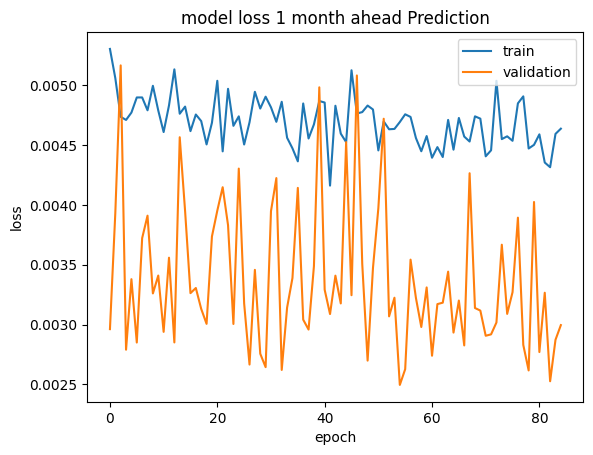

3/3 [==============================] - 0s 5ms/step
    Test Predictions  Actuals
60          7.655108     7.63
61          7.872519     7.89
62          8.015200     7.97
63          7.993601     8.02
64          8.118965     8.04
Root Mean Squared Error (RMSE): 0.12
NSE Score: 0.82
R-squared (R2) Score: 0.82
Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.09
RSR (RSR): 0.43
KGE_09 Score: 0.88
KGE_12 Score: 0.88


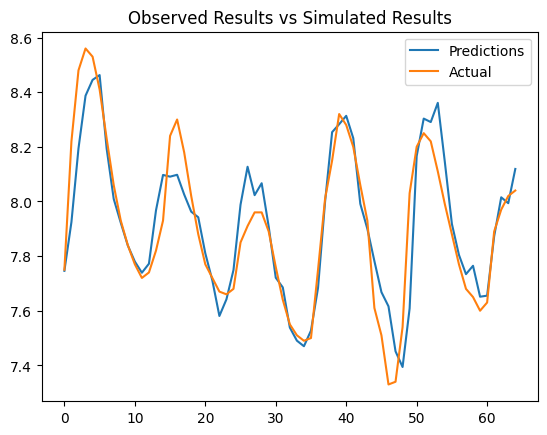

Model saved successfully.


In [ ]:
print("Beginning Adaptation")
import time
# Create the model using the best parameters
# best_model = create_model(batch_size=8, lstm_units=128, dropout_rate=0.1, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.27))
# Start the timer
start_time = time.time()
# Train the model with the entire training data
history = best_model.fit(X_train, y_train, validation_split=0.15, epochs=200, batch_size=8, callbacks=callbacks)
# End the timer
end_time = time.time()
# Calculate the elapsed time
training_time = end_time - start_time
# Evaluate the model on the test data
loss, mae, rmse = best_model.evaluate(X_train, y_train)
print("Training time:", training_time, "seconds")
print("Train Loss:", loss)
print("Train MAE:", mae)
print("Train RMSE:", rmse)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss 1 month ahead Prediction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
# y_test = scaler.inverse_transform(y_test)
predictions_1d = np.ravel(predictions)
# y_test_1d = np.ravel(y_test)
test_results = pd.DataFrame(data={'Test Predictions':predictions_1d, 'Actuals':y_test_1d})
print(test_results.tail())
evaluate_predictions(test_results)

# y_true = test_results['Actuals']
# y_pred = test_results['Test Predictions']
# # Calculate metrics
# mse = mean_squared_error(y_true, y_pred)
# mae = mean_absolute_error(y_true, y_pred)
# rmse = np.sqrt(mse)
# r2 = he.r_squared(y_pred, y_true)
# NSE1=he.nse(y_pred, y_true)
# KGE_12= he.kge_2012(y_pred, y_true)
# print("After Adaptation:")
# print("Mean Squared Error (MSE): {:.2f}".format(mse))
# print("Mean Absolute Error (MAE): {:.2f}".format(mae))
# print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
# print("NSE Score: {:.2f}".format(NSE1))
# print("R-squared (R2) Score: {:.2f}".format(r2))
# print("KGE_12 Score: {:.2f}".format(KGE_12))
# # Visualize results
# import matplotlib.pyplot as plt
# plt.plot(y_pred, label='Predictions')
# plt.plot(y_true, label='Actual')
# plt.title('obreveved Results vs Simulated Results (1 month ahead)')
# plt.legend()
# plt.show()

# Save the trained model
best_model.save(adapted_model_path)
print("Model saved successfully.")

# Assuming test_results is your DataFrame
test_results.to_csv(save_csv_path, index=False)

In [ ]:
# best_model.summary()

In [ ]:
# def rmse(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)]

# def create_model(batch_size=16, optimizer='SGD', activation='leaky_relu', dropout_rate=0.2, lstm_units=128, dense_units=64, seed_value=42, model_path=''):
#     np.random.seed(seed_value)  # Set seed for NumPy
#     model = Sequential()
#     model.add(LSTM(lstm_units, return_sequences=True, input_shape=(1, 13)))

#     if activation == 'leaky_relu':
#         model.add(LeakyReLU(alpha=0.5))
#     else:
#         model.add(Activation(activation))

#     model.add(LSTM(lstm_units, return_sequences=True))

#     if activation == 'leaky_relu':
#         model.add(LeakyReLU(alpha=0.2))
#     else:
#         model.add(Activation(activation))

#     model.add(Dropout(dropout_rate))
#     model.add(LSTM(int(lstm_units/2), return_sequences=False))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(dense_units))
#     model.add(Dense(1))

#     if optimizer == 'SGD':
#         optimizer = SGD()
#     elif optimizer == 'RMSprop':
#         optimizer = RMSprop()
#     elif optimizer == 'Adam':
#         optimizer = Adam()

#     # Load the weights
#     # model.load_weights(model_path)
#     # # Freeze all layers
#     # for layer in model.layers:
#     #     layer.trainable = False
#     for layer in model.layers[:-4]:
#         layer.trainable = False

#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae', rmse])

#     return model

# best_model = create_model(batch_size=8, lstm_units=128, dropout_rate=0.15, dense_units=64, optimizer='Adam', activation=LeakyReLU(alpha=0.25), model_path='NewSavedModels/avg_3_month.keras')

In [ ]:
# best_model.get_config()

In [ ]:
best_model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>